In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error as mape,mean_absolute_error as mae
from keras import optimizers

# Prepare Data hourtime

In [57]:
def preparedata_hourtime(file):
    cloud_cover = pd.read_csv(file,skipinitialspace = True)
    cloud_cover['Date'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
    cloud_cover['Time'] = cloud_cover[['Hour']].apply(lambda x: "{}".format(str(x[0]).zfill(2)), axis=1)
    cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)  
    cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
    cloud_cover = cloud_cover.groupby(['Date', 'Time']).agg(cloud_cover=('cloud_cover','mean')).reset_index()
    cloud_cover['DateTime'] = cloud_cover[['Date', 'Time']].apply(lambda x: "{} {}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Date", "Time"], axis=1, inplace=True)        
    cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d %H:%M")
    cloud_cover.dropna(inplace=True)
    return cloud_cover


In [58]:
cloud_cover = preparedata_hourtime('../prophet_ver2/Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv')
cloud_cover

,cloud_cover,DateTime
0,0.990899,2021-11-16 11:00:00
1,0.973114,2021-11-16 12:00:00
2,0.960600,2021-11-16 13:00:00
3,0.908915,2021-11-16 14:00:00
4,0.631449,2021-11-16 15:00:00
...,...,...
251,0.480200,2021-12-16 10:00:00
252,0.155117,2021-12-16 11:00:00
253,0.161317,2021-12-16 12:00:00
254,0.174650,2021-12-16 13:00:00


In [59]:
def lags_train_test(data, lags):
	X, y = [], []
	for i in range(lags, len(data)):
		X.append(data[i-lags:i])
		y.append(data[i])
	return np.array(X), np.array(y)

In [60]:
def Xtrain_ytrain(train,test,lags):
    #scale train
    sc = MinMaxScaler()
    sc.fit(train)
    train_set_scale = sc.transform(train)
    # train
    X_train, y_train = lags_train_test(train_set_scale, lags)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print("X_train Shape :", X_train.shape)
    print("y_train Shape :", y_train.shape)

    #scale test
    dataset_total = pd.concat((train['cloud_cover'], test['cloud_cover']), axis=0)
    inputs = dataset_total[len(dataset_total) - len(test) - lags:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    # test
    X_test, y_test = lags_train_test(inputs, lags)
    print("X_test Shape : ", X_test.shape)
    print("y_test Shape : ", y_test.shape)
    return X_train, y_train, X_test, y_test, sc

In [61]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [62]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [63]:
def plot_test(train,pred):
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['cloud_cover'], name = 'Actual'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['LSTM'], name = 'Predict'))
    fig2.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
    )


    fig2.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=2,
                        label="2.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=3,
                        label="3.zoom",
                        step="day",
                        stepmode="backward"),              

                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig2.show()

## Train/Test Model

In [64]:
train,test = train_test_split(cloud_cover, train_size=0.8, shuffle=False)
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (204, 2)
Test Shape (52, 2)


In [65]:
train

,cloud_cover,DateTime
0,0.990899,2021-11-16 11:00:00
1,0.973114,2021-11-16 12:00:00
2,0.960600,2021-11-16 13:00:00
3,0.908915,2021-11-16 14:00:00
4,0.631449,2021-11-16 15:00:00
...,...,...
199,0.132593,2021-12-10 11:00:00
200,0.638319,2021-12-10 12:00:00
201,0.712340,2021-12-10 13:00:00
202,0.515441,2021-12-10 14:00:00


In [66]:
test

,cloud_cover,DateTime
204,0.294850,2021-12-10 16:00:00
205,0.863067,2021-12-11 08:00:00
206,0.670333,2021-12-11 09:00:00
207,0.886633,2021-12-11 10:00:00
208,0.505052,2021-12-11 11:00:00
209,0.467982,2021-12-11 12:00:00
210,0.407017,2021-12-11 13:00:00
211,0.247034,2021-12-11 14:00:00
212,0.224317,2021-12-11 15:00:00
213,0.564383,2021-12-11 16:00:00


In [67]:
train = train.set_index('DateTime')
test = test.set_index('DateTime')

In [68]:
# X_train, y_train, X_test and y_test
X_train, y_train, X_test, y_test, sc = Xtrain_ytrain(train,test,5)

X_train Shape : (199, 5, 1)
y_train Shape : (199, 1)
X_test Shape :  (52, 5, 1)
y_test Shape :  (52, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



### Add frist layer units = 100 batch size 32  epochs 20

In [69]:
model = Sequential()
model.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train.shape[1], 1)))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 20, batch_size = 32)

Epoch 1/20
7/7 [==============================] - 4s 162ms/step - loss: 0.3057 - val_loss: 0.1038
Epoch 2/20
7/7 [==============================] - 0s 13ms/step - loss: 0.1220 - val_loss: 0.0614
Epoch 3/20
7/7 [==============================] - 0s 12ms/step - loss: 0.0772 - val_loss: 0.0871
Epoch 4/20
7/7 [==============================] - 0s 12ms/step - loss: 0.0861 - val_loss: 0.0680
Epoch 5/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0719 - val_loss: 0.0581
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 0.0731 - val_loss: 0.0567
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0738 - val_loss: 0.0565
Epoch 8/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0704 - val_loss: 0.0614
Epoch 9/20
7/7 [==============================] - 0s 15ms/step - loss: 0.0696 - val_loss: 0.0598
Epoch 10/20
7/7 [==============================] - 0s 15ms/step - loss: 0.0683 - val_loss: 0.0578
Epoch 11/20
7/7 [===========

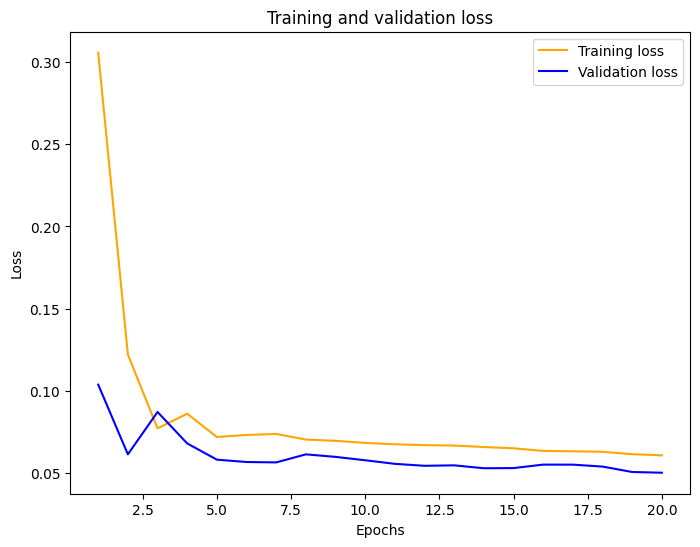

In [70]:
plot_curve(hist)

In [71]:
predict_scaled = model.predict(X_test)
predict = sc.inverse_transform(predict_scaled)

2/2 [==============================] - 1s 6ms/step


In [72]:
train1 = train.copy()
test1 = test.copy()

In [73]:
train1.reset_index(inplace=True)
test1.reset_index(inplace=True)

In [74]:
test1['LSTM'] = predict
test1

,DateTime,cloud_cover,LSTM
0,2021-12-10 16:00:00,0.294850,0.526679
1,2021-12-11 08:00:00,0.863067,0.502342
2,2021-12-11 09:00:00,0.670333,0.548654
3,2021-12-11 10:00:00,0.886633,0.565157
4,2021-12-11 11:00:00,0.505052,0.631541
5,2021-12-11 12:00:00,0.467982,0.611942
6,2021-12-11 13:00:00,0.407017,0.589292
7,2021-12-11 14:00:00,0.247034,0.521883
8,2021-12-11 15:00:00,0.224317,0.448947
9,2021-12-11 16:00:00,0.564383,0.375185


In [104]:
plot_test(train1,test1)

In [76]:
lstm_mae_error = mae(test1["cloud_cover"], test1["LSTM"])
lstm_mape_error = mape(test1["cloud_cover"], test1["LSTM"])
lstm_mse_error = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=True)
lstm_rmse_error = mean_squared_error(test1["cloud_cover"], test1["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error)
print('MAPE Error :  %.5f'%lstm_mape_error)
print('MSE Error : %.5f'%lstm_mse_error)
print('RMSE Error :  %.5f'%lstm_rmse_error)

MAE Error :  0.19347
MAPE Error :  1.20508
MSE Error : 0.04797
RMSE Error :  0.21903


---

## Train/Test Model data use last day

In [77]:
train4 = cloud_cover[cloud_cover['DateTime'] < '2021-12-16 00:00:00']
test4 = cloud_cover[cloud_cover['DateTime'] >= '2021-12-16 00:00:00']

print('train Shape', train4.shape)
print('test Shape', test4.shape)

train Shape (250, 2)
test Shape (6, 2)


In [78]:
train4

,cloud_cover,DateTime
0,0.990899,2021-11-16 11:00:00
1,0.973114,2021-11-16 12:00:00
2,0.960600,2021-11-16 13:00:00
3,0.908915,2021-11-16 14:00:00
4,0.631449,2021-11-16 15:00:00
...,...,...
245,0.073203,2021-12-15 12:00:00
246,0.056172,2021-12-15 13:00:00
247,0.087286,2021-12-15 14:00:00
248,0.070797,2021-12-15 15:00:00


In [79]:
test4

,cloud_cover,DateTime
250,0.161860,2021-12-16 09:00:00
251,0.480200,2021-12-16 10:00:00
252,0.155117,2021-12-16 11:00:00
253,0.161317,2021-12-16 12:00:00
254,0.174650,2021-12-16 13:00:00
255,0.145333,2021-12-16 14:00:00


In [80]:
train4 = train4.set_index('DateTime')
test4 = test4.set_index('DateTime')

In [81]:
# X_train, y_train, X_test and y_test
X_train3, y_train3, X_test3, y_test3, sc3 = Xtrain_ytrain(train4,test4,5)

X_train Shape : (245, 5, 1)
y_train Shape : (245, 1)
X_test Shape :  (6, 5, 1)
y_test Shape :  (6, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



### Add frist layer units = 50 batch size 32  epochs 10 lr 0.005

In [82]:
model3 = Sequential()
model3.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train3.shape[1], 1)))
model3.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model3.compile(optimizer = opt, loss = 'mean_squared_error')
hist3 = model3.fit(X_train3, y_train3, validation_data=(X_test3, y_test3),  epochs = 10, batch_size = 32)

Epoch 1/10
8/8 [==============================] - 3s 85ms/step - loss: 0.1904 - val_loss: 0.0684
Epoch 2/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0864 - val_loss: 0.0232
Epoch 3/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0707 - val_loss: 0.0259
Epoch 4/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0628 - val_loss: 0.0320
Epoch 5/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0616 - val_loss: 0.0242
Epoch 6/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0583 - val_loss: 0.0241
Epoch 7/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0566 - val_loss: 0.0256
Epoch 8/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0543 - val_loss: 0.0229
Epoch 9/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0526 - val_loss: 0.0237
Epoch 10/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0505 - val_loss: 0.0245


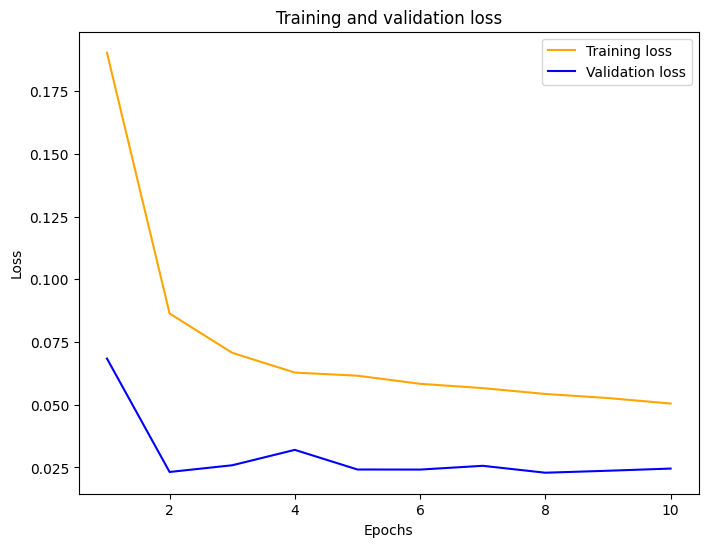

In [83]:
plot_curve(hist3)

In [84]:
predict_scaled3 = model3.predict(X_test3)
predict3 = sc3.inverse_transform(predict_scaled3)

1/1 [==============================] - 1s 614ms/step


In [85]:
train5 = train4.copy()
test5 = test4.copy()

In [86]:
train5.reset_index(inplace=True)
test5.reset_index(inplace=True)

In [87]:
test5['LSTM'] = predict3
test5

,DateTime,cloud_cover,LSTM
0,2021-12-16 09:00:00,0.161860,0.225112
1,2021-12-16 10:00:00,0.480200,0.237880
2,2021-12-16 11:00:00,0.155117,0.334650
3,2021-12-16 12:00:00,0.161317,0.307527
4,2021-12-16 13:00:00,0.174650,0.279538
5,2021-12-16 14:00:00,0.145333,0.261050


In [88]:
plot_test(train5,test5)

In [89]:
lstm_mae_error2 = mae(test5["cloud_cover"], test5["LSTM"])
lstm_mape_error2 = mape(test5["cloud_cover"], test5["LSTM"])
lstm_mse_error2 = mean_squared_error(test5['cloud_cover'], test5['LSTM'], squared=True)
lstm_rmse_error2 = mean_squared_error(test5["cloud_cover"], test5["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error2)
print('MAPE Error :  %.5f'%lstm_mape_error2)
print('MSE Error : %.5f'%lstm_mse_error2)
print('RMSE Error :  %.5f'%lstm_rmse_error2)

MAE Error :  0.14199
MAPE Error :  0.72599
MSE Error : 0.02345
RMSE Error :  0.15315


---

# Prepare Data to DateTime

In [90]:
def preparedata_datetime(file):
    cloud_cover = pd.read_csv(file,skipinitialspace = True)
    cloud_cover['DateTime'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
    cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)  
    cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
    cloud_cover = cloud_cover.groupby(['DateTime']).agg(cloud_cover=('cloud_cover','mean')).reset_index()    
    cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d")
    cloud_cover.dropna(inplace=True)
    return cloud_cover

In [91]:
cloud_cover2 = preparedata_datetime('../prophet_ver2/Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv')
cloud_cover2

,DateTime,cloud_cover
0,2021-11-16,0.769193
1,2021-11-17,0.364608
2,2021-11-18,0.878172
3,2021-11-19,0.529353
4,2021-11-20,0.449684
5,2021-11-21,0.443777
6,2021-11-22,0.496665
7,2021-11-23,0.954683
8,2021-11-24,0.665824
9,2021-11-25,0.369516


## Train/Test Model

In [92]:
train2,test2 = train_test_split(cloud_cover2, train_size=0.8, shuffle=False)
print('Train Shape', train2.shape)
print('Test Shape', test2.shape)

Train Shape (24, 2)
Test Shape (6, 2)


In [93]:
train2

,DateTime,cloud_cover
0,2021-11-16,0.769193
1,2021-11-17,0.364608
2,2021-11-18,0.878172
3,2021-11-19,0.529353
4,2021-11-20,0.449684
5,2021-11-21,0.443777
6,2021-11-22,0.496665
7,2021-11-23,0.954683
8,2021-11-24,0.665824
9,2021-11-25,0.369516


In [94]:
test2

,DateTime,cloud_cover
24,2021-12-11,0.539296
25,2021-12-12,0.671356
26,2021-12-13,0.476423
27,2021-12-14,0.260594
28,2021-12-15,0.085025
29,2021-12-16,0.228007


In [95]:
train2 = train2.set_index('DateTime')
test2 = test2.set_index('DateTime')

In [96]:
# X_train, y_train, X_test and y_test
X_train1, y_train1, X_test1, y_test1, sc1 = Xtrain_ytrain(train2,test2,5)

X_train Shape : (19, 5, 1)
y_train Shape : (19, 1)
X_test Shape :  (6, 5, 1)
y_test Shape :  (6, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [97]:
model1 = Sequential()
model1.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train1.shape[1], 1)))
model1.add(Dense(units = 1))
model1.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist1 = model1.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs = 20, batch_size = 32)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.3717 - val_loss: 0.1537
Epoch 2/20
1/1 [==============================] - 0s 48ms/step - loss: 0.3388 - val_loss: 0.1403
Epoch 3/20
1/1 [==============================] - 0s 38ms/step - loss: 0.3084 - val_loss: 0.1282
Epoch 4/20
1/1 [==============================] - 0s 40ms/step - loss: 0.2803 - val_loss: 0.1172
Epoch 5/20
1/1 [==============================] - 0s 50ms/step - loss: 0.2545 - val_loss: 0.1073
Epoch 6/20
1/1 [==============================] - 0s 40ms/step - loss: 0.2310 - val_loss: 0.0987
Epoch 7/20
1/1 [==============================] - 0s 38ms/step - loss: 0.2097 - val_loss: 0.0912
Epoch 8/20
1/1 [==============================] - 0s 48ms/step - loss: 0.1908 - val_loss: 0.0849
Epoch 9/20
1/1 [==============================] - 0s 49ms/step - loss: 0.1742 - val_loss: 0.0800
Epoch 10/20
1/1 [==============================] - 0s 49ms/step - loss: 0.1601 - val_loss: 0.0765
Epoch 11/20
1/1 [==============

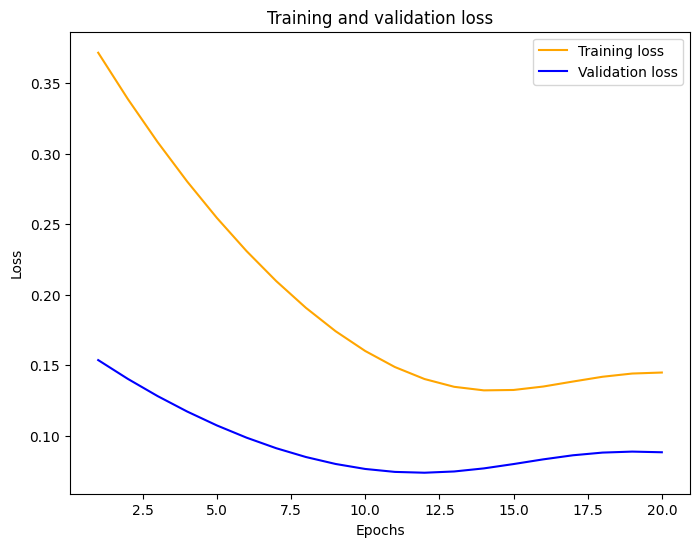

In [98]:
plot_curve(hist1)

In [99]:
predict_scaled1 = model1.predict(X_test1)
predict1 = sc1.inverse_transform(predict_scaled1)
predict1

1/1 [==============================] - 1s 519ms/step


array([[0.42933336],
       [0.33280334],
       [0.40244386],
       [0.48386368],
       [0.5287566 ],
       [0.5170717 ]], dtype=float32)

In [100]:
train3 = train2.copy()
test3 = test2.copy()
train3.reset_index(inplace=True)
test3.reset_index(inplace=True)

In [101]:
test3['LSTM'] = predict1
test3

,DateTime,cloud_cover,LSTM
0,2021-12-11,0.539296,0.429333
1,2021-12-12,0.671356,0.332803
2,2021-12-13,0.476423,0.402444
3,2021-12-14,0.260594,0.483864
4,2021-12-15,0.085025,0.528757
5,2021-12-16,0.228007,0.517072


In [102]:
plot_test(train3,test3)

In [103]:
lstm_mae_error1 = mae(test3["cloud_cover"], test3["LSTM"])
lstm_mape_error1 = mape(test3["cloud_cover"], test3["LSTM"])
lstm_mse_error1 = mean_squared_error(test3['cloud_cover'], test3['LSTM'], squared=True)
lstm_rmse_error1 = mean_squared_error(test3["cloud_cover"], test3["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error1)
print('MAPE Error :  %.5f'%lstm_mape_error1)
print('MSE Error : %.5f'%lstm_mse_error1)
print('RMSE Error :  %.5f'%lstm_rmse_error1)

MAE Error :  0.24643
MAPE Error :  1.36781
MSE Error : 0.07708
RMSE Error :  0.27764


----